# Following
https://www.kaggle.com/code/motono0223/isic-pytorch-training-baseline-image-only

In [34]:
!pip install torcheval

In [35]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

import joblib
from tqdm import tqdm
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Training Configuration

In [36]:
CONFIG = dict(seed = 42,
             epochs = 50,
             img_size = 384,
             model_name = "tf_efficientnet_b0_ns",
            checkpoint_path = "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
              train_batch_size = 32,
              valid_batch_size = 64,
              learning_rate = 1e-4,
              scheduler = "CosineAnnealingLR",
              min_lr = 1e-6,
              T_max = 500,
              weight_decay = 1e-6,
              fold = 0,
              n_fold = 5,
              n_accumulate = 1,
              device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
             )
CONFIG

{'seed': 42,
 'epochs': 50,
 'img_size': 384,
 'model_name': 'tf_efficientnet_b0_ns',
 'checkpoint_path': '/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth',
 'train_batch_size': 32,
 'valid_batch_size': 64,
 'learning_rate': 0.0001,
 'scheduler': 'CosineAnnealingLR',
 'min_lr': 1e-06,
 'T_max': 500,
 'weight_decay': 1e-06,
 'fold': 0,
 'n_fold': 5,
 'n_accumulate': 1,
 'device': device(type='cuda', index=0)}

# Set Seed for Reproducibility

In [37]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ["PYTONHASHSEED"] = str(seed)

    
set_seed(CONFIG["seed"])

In [38]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f"{ROOT_DIR}/train-image/image"

In [39]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [40]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [41]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("            def.shape, # of positivecases, # of patiente")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])
print("filterd>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df["file_path"] = df["isic_id"].apply(get_train_file_path)
df = df[df["file_path"].isin(train_images)].reset_index(drop=True)
df

            def.shape, # of positivecases, # of patiente
original> (401059, 55) 393 (1042,)
filterd> (8253, 55) 393 (950,)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...


In [42]:
df.shape[0], df.target.sum()

(8253, 393)

In [43]:
df.target.value_counts()

target
0    7860
1     393
Name: count, dtype: int64

In [44]:
print(CONFIG["T_max"])
CONFIG["T_max"] = df.shape[0] * (CONFIG["n_fold"] - 1) * CONFIG["epochs"]\
                // CONFIG["train_batch_size"] // CONFIG["n_fold"]
CONFIG["T_max"]

500


10316

# Create Folds

In [45]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG["n_fold"])


for fold, (_, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
    df.loc[val_, "kfold"] = int(fold)

In [46]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path,kfold
0,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683,/kaggle/input/isic-2024-challenge/train-image/...,0.0
1,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/kaggle/input/isic-2024-challenge/train-image/...,2.0
2,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/kaggle/input/isic-2024-challenge/train-image/...,2.0
3,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/kaggle/input/isic-2024-challenge/train-image/...,0.0
4,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/kaggle/input/isic-2024-challenge/train-image/...,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8248,ISIC_0267522,0,IP_9577633,50.0,male,lower extremity,4.94,TBP tile: close-up,3D: XP,21.738880,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,96.325510,/kaggle/input/isic-2024-challenge/train-image/...,4.0
8249,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/kaggle/input/isic-2024-challenge/train-image/...,4.0
8250,ISIC_0267568,0,IP_0379091,60.0,male,anterior torso,3.45,TBP tile: close-up,3D: white,13.901465,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,72.961688,/kaggle/input/isic-2024-challenge/train-image/...,1.0
8251,ISIC_0267594,0,IP_1433033,70.0,NaN,lower extremity,3.00,TBP tile: close-up,3D: XP,17.986882,...,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.899274,/kaggle/input/isic-2024-challenge/train-image/...,1.0


# Dataset Class

In [47]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"]==1].reset_index()
        self.df_negative = df[df["target"]==0].reset_index()
        self.file_names_positive = self.df_positive["file_path"].values
        self.file_names_negative = self.df_negative["file_path"].values
        self.targets_positive = self.df_positive["target"].values
        self.targets_negative = self.df_negative["target"].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive 
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            "image":img,
            "target":target
        }

In [48]:
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df["file_path"].values
        self.targets = df["target"].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self. transforms(image=img)["image"]
            
        return {
            "image":img,
            "target":target
        }

# Augmentations

In [49]:
data_transforms  = {
    "train":A.Compose([
        A.Resize(CONFIG["img_size"], CONFIG["img_size"]),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
            hue_shift_limit=0.2,
            sat_shift_limit=0.2,
            val_shift_limit=0.2,
            p=0.5),
        A.RandomBrightnessContrast(
        brightness_limit=(-0.1, 0.1),
        contrast_limit=(-0.1, 0.1),
        p=0.5),
        A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=225.0,
        p=1.0),
        ToTensorV2()
        
    ],
    p=1.),
    "valid":A.Compose([
        A.Resize(CONFIG["img_size"], CONFIG["img_size"]),
        A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0),
        ToTensorV2()
    ],
    p=1.)
    
}

# GeM Pooling

In [50]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
        
    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p),
                           (x.size(-2),
                           x.size(-1))).pow(1./p)
    
    def __repr__(self):
        return self.__class__.__name__ +\
                    "(" + "p=" + "{:.4f}".format(self.p.data.tolist()[0]) +\
                    ", " + "eps=" + str(self.eps) + ")"

# Create Model

In [51]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, 
                checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                      checkpoint_path=checkpoint_path)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output
    
model = ISICModel(CONFIG["model_name"], checkpoint_path=None)#CONFIG["checkpoint_path"])
model.to(CONFIG["device"]);

# Loss Function

In [52]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# Training Function

In [53]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data["image"].to(device, dtype=torch.float)
        targets = data["target"].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG["n_accumulate"]
        
        loss.backward()
        
        if (step+1) % CONFIG["n_accumulate"] == 0:
            optimizer.step()
            
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                       LR=optimizer.param_groups[0]["lr"])
        
    gc.collect()
    
    return epoch_loss, epoch_auroc

# Validation Function

In [54]:
@torch.inference_mode()
def valid_one_epoch(mode, dataloader, device, epoch):
    model.eval() 
    
    dataset_size = 0
    running_loss = 0.0 
    running_auroc = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data["image"].to(device, dtype=torch.float)
        targets = data["target"].to(device, dtype=torch.float)
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                       LR=optimizer.param_groups[0]["lr"])
    gc.collect()
    
    return epoch_loss, epoch_auroc

# Run Training

In [55]:
a = defaultdict(list)
a["test"].append(1)
a

defaultdict(list, {'test': [1]})

In [56]:
def run_training(mode, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler,
                                                             dataloader=train_loader,
                                                             device=CONFIG["device"], epoch=epoch)
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG["device"],
                                                         epoch=epoch)
        
        history["Train Loss"].append(train_epoch_loss)
        history["Valid Loss"].append(val_epoch_loss)
        history["Train AUROC"].append(train_epoch_auroc)
        history["Valid AUROC"].append(val_epoch_auroc)
        history["lr"].append( scheduler.get_lr()[0])
        
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} --> {val_epoch_auroc})")
            
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc,
                                                                  val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")
            
        print()
        
    end = time.time()
    time_elapsed = end - start
    print("Training complete in {:.0f}h {:.0f}m {:.0f}s".format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    model.load_state_dict(best_model_wts)
    return model, history

In [57]:
x = 550
print(x//3600, (x%3600), (x%3600)//60, (x%3600)%60)

0 550 9 10


In [58]:
def fetch_scheduler(optimizer):
    if CONFIG["scheduler"] == "CosineAnnealingLR":
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["T_max"],
                                                 eta_min=CONFIG["min_lr"])
    elif CONFIG["scheduler"] == "CosineAnnealingWarmRestarts":
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG["T_0"],
                                                            eta_min=CONFIG)
    elif CONFIG["scheduler"] == None:
        return None
    
    return scheduler

In [59]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG["train_batch_size"],
                             num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG["valid_batch_size"],
                             num_workers=2, shuffle=False, pin_memory=True)
    return train_loader, valid_loader

## Prepare Dataloaders

In [60]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

## Define Optimizer and Scheduler

In [61]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"],
                      weight_decay=CONFIG["weight_decay"])
scheduler = fetch_scheduler(optimizer)

## Start Training

In [62]:
%%time
model, history = run_training(model, optimizer, scheduler,
                             device=CONFIG["device"],
                             num_epochs=CONFIG["epochs"])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 26/26 [00:06<00:00,  3.89it/s, Epoch=1, LR=0.0001, Valid_Auroc=0.507, Valid_Loss=0.816]


Validation AUROC Improved (-inf --> 0.5070936187921564)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.19it/s, Epoch=2, LR=0.0001, Valid_Auroc=0.509, Valid_Loss=0.811]


Validation AUROC Improved (0.5070936187921564 --> 0.5085176166166042)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.85it/s, Epoch=3, LR=0.0001, Valid_Auroc=0.508, Valid_Loss=0.785]


100%|██████████| 26/26 [00:06<00:00,  4.11it/s, Epoch=4, LR=0.0001, Valid_Auroc=0.511, Valid_Loss=0.565]


Validation AUROC Improved (0.5085176166166042 --> 0.5112073902850056)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.12it/s, Epoch=5, LR=0.0001, Valid_Auroc=0.513, Valid_Loss=0.625]


Validation AUROC Improved (0.5112073902850056 --> 0.5127896100899475)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.23it/s, Epoch=6, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.579]


Validation AUROC Improved (0.5127896100899475 --> 0.5148992364965368)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.17it/s, Epoch=7, LR=0.0001, Valid_Auroc=0.515, Valid_Loss=0.612]


Validation AUROC Improved (0.5148992364965368 --> 0.5150047178168663)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.19it/s, Epoch=8, LR=9.99e-5, Valid_Auroc=0.515, Valid_Loss=0.478]


100%|██████████| 26/26 [00:06<00:00,  4.19it/s, Epoch=9, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.34] 


Validation AUROC Improved (0.5150047178168663 --> 0.5156376057388431)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.11it/s, Epoch=10, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.278]


Validation AUROC Improved (0.5156376057388431 --> 0.5157958277193373)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.02it/s, Epoch=11, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.35] 


Validation AUROC Improved (0.5157958277193373 --> 0.5159013090396667)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.16it/s, Epoch=12, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.183]


Validation AUROC Improved (0.5159013090396667 --> 0.516059531020161)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.10it/s, Epoch=13, LR=9.99e-5, Valid_Auroc=0.516, Valid_Loss=0.664]


Validation AUROC Improved (0.516059531020161 --> 0.5161122716803257)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.08it/s, Epoch=14, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.295]


Validation AUROC Improved (0.5161122716803257 --> 0.5165869376218083)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.09it/s, Epoch=15, LR=9.98e-5, Valid_Auroc=0.516, Valid_Loss=0.192]


100%|██████████| 26/26 [00:06<00:00,  4.15it/s, Epoch=16, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.28] 


Validation AUROC Improved (0.5165869376218083 --> 0.5166924189421378)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.14it/s, Epoch=17, LR=9.98e-5, Valid_Auroc=0.517, Valid_Loss=0.288]


100%|██████████| 26/26 [00:06<00:00,  4.16it/s, Epoch=18, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.255]


Validation AUROC Improved (0.5166924189421378 --> 0.5166924189421378)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.22it/s, Epoch=19, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.268]


Validation AUROC Improved (0.5166924189421378 --> 0.5167451596023024)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.05it/s, Epoch=20, LR=9.97e-5, Valid_Auroc=0.517, Valid_Loss=0.297]


Validation AUROC Improved (0.5167451596023024 --> 0.5167979002624672)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.06it/s, Epoch=21, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.261]


Validation AUROC Improved (0.5167979002624672 --> 0.5169561222429614)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.99it/s, Epoch=22, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.266]


Validation AUROC Improved (0.5169561222429614 --> 0.517430788184444)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.10it/s, Epoch=23, LR=9.96e-5, Valid_Auroc=0.517, Valid_Loss=0.288]


100%|██████████| 26/26 [00:06<00:00,  3.87it/s, Epoch=24, LR=9.95e-5, Valid_Auroc=0.517, Valid_Loss=0.283]


Validation AUROC Improved (0.517430788184444 --> 0.517430788184444)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.23it/s, Epoch=25, LR=9.95e-5, Valid_Auroc=0.517, Valid_Loss=0.365]


Validation AUROC Improved (0.517430788184444 --> 0.5174835288446087)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  3.90it/s, Epoch=26, LR=9.94e-5, Valid_Auroc=0.518, Valid_Loss=0.31] 


Validation AUROC Improved (0.5174835288446087 --> 0.5175362695047735)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.26it/s, Epoch=27, LR=9.94e-5, Valid_Auroc=0.518, Valid_Loss=0.281]


Validation AUROC Improved (0.5175362695047735 --> 0.5176944914852677)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.10it/s, Epoch=28, LR=9.94e-5, Valid_Auroc=0.518, Valid_Loss=0.355]


100%|██████████| 26/26 [00:06<00:00,  4.06it/s, Epoch=29, LR=9.93e-5, Valid_Auroc=0.518, Valid_Loss=0.321]


Validation AUROC Improved (0.5176944914852677 --> 0.5177999728055971)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.04it/s, Epoch=30, LR=9.93e-5, Valid_Auroc=0.517, Valid_Loss=0.259]


100%|██████████| 26/26 [00:06<00:00,  4.14it/s, Epoch=31, LR=9.92e-5, Valid_Auroc=0.517, Valid_Loss=0.347]


100%|██████████| 26/26 [00:06<00:00,  4.13it/s, Epoch=32, LR=9.92e-5, Valid_Auroc=0.518, Valid_Loss=0.292]


100%|██████████| 26/26 [00:06<00:00,  4.12it/s, Epoch=33, LR=9.91e-5, Valid_Auroc=0.518, Valid_Loss=0.267]


100%|██████████| 26/26 [00:06<00:00,  4.06it/s, Epoch=34, LR=9.9e-5, Valid_Auroc=0.517, Valid_Loss=0.283]


100%|██████████| 26/26 [00:06<00:00,  4.01it/s, Epoch=35, LR=9.9e-5, Valid_Auroc=0.517, Valid_Loss=0.368]


100%|██████████| 26/26 [00:06<00:00,  4.23it/s, Epoch=36, LR=9.89e-5, Valid_Auroc=0.517, Valid_Loss=0.336]


100%|██████████| 26/26 [00:06<00:00,  4.13it/s, Epoch=37, LR=9.89e-5, Valid_Auroc=0.518, Valid_Loss=0.576]


Validation AUROC Improved (0.5177999728055971 --> 0.5177999728055971)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.08it/s, Epoch=38, LR=9.88e-5, Valid_Auroc=0.517, Valid_Loss=0.316]


100%|██████████| 26/26 [00:06<00:00,  4.18it/s, Epoch=39, LR=9.87e-5, Valid_Auroc=0.518, Valid_Loss=0.425]


Validation AUROC Improved (0.5177999728055971 --> 0.5179054541259266)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.04it/s, Epoch=40, LR=9.87e-5, Valid_Auroc=0.518, Valid_Loss=0.279]


100%|██████████| 26/26 [00:06<00:00,  4.28it/s, Epoch=41, LR=9.86e-5, Valid_Auroc=0.517, Valid_Loss=0.302]


100%|██████████| 26/26 [00:06<00:00,  3.93it/s, Epoch=42, LR=9.85e-5, Valid_Auroc=0.518, Valid_Loss=0.372]


100%|██████████| 26/26 [00:06<00:00,  4.08it/s, Epoch=43, LR=9.85e-5, Valid_Auroc=0.517, Valid_Loss=0.309]


100%|██████████| 26/26 [00:06<00:00,  4.10it/s, Epoch=44, LR=9.84e-5, Valid_Auroc=0.517, Valid_Loss=0.337]


100%|██████████| 26/26 [00:06<00:00,  4.02it/s, Epoch=45, LR=9.83e-5, Valid_Auroc=0.517, Valid_Loss=0.331]


100%|██████████| 26/26 [00:06<00:00,  4.25it/s, Epoch=46, LR=9.83e-5, Valid_Auroc=0.517, Valid_Loss=0.372]


100%|██████████| 26/26 [00:06<00:00,  3.87it/s, Epoch=47, LR=9.82e-5, Valid_Auroc=0.517, Valid_Loss=0.36] 


100%|██████████| 26/26 [00:06<00:00,  4.13it/s, Epoch=48, LR=9.81e-5, Valid_Auroc=0.517, Valid_Loss=0.33] 


100%|██████████| 26/26 [00:06<00:00,  3.91it/s, Epoch=49, LR=9.8e-5, Valid_Auroc=0.518, Valid_Loss=0.338]


Validation AUROC Improved (0.5179054541259266 --> 0.518010935446256)
Model Saved



100%|██████████| 26/26 [00:06<00:00,  4.14it/s, Epoch=50, LR=9.79e-5, Valid_Auroc=0.518, Valid_Loss=0.391]



Training complete in 0h 12m 39s
Best AUROC: 0.5180
CPU times: user 11min 9s, sys: 1min 11s, total: 12min 21s
Wall time: 12min 39s


In [63]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# Logs

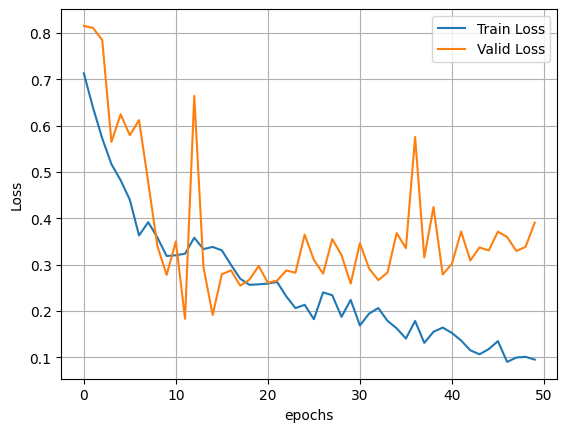

In [64]:
plt.plot(range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot(range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

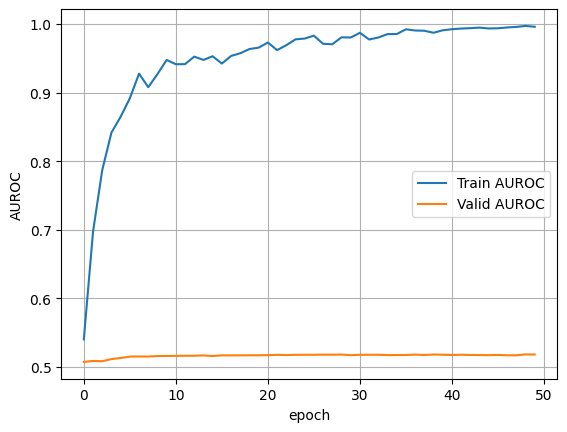

In [65]:
plt.plot(range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot(range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epoch")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

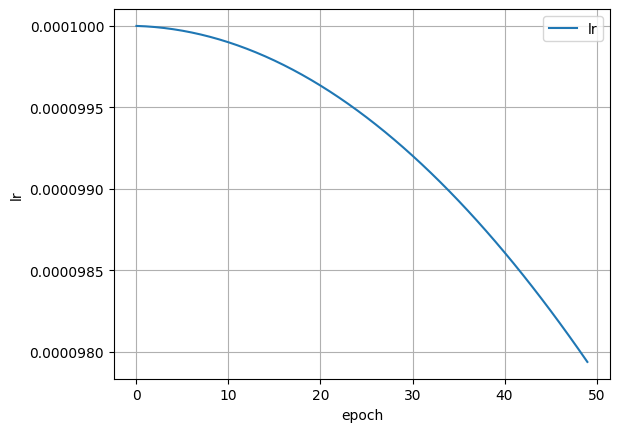

In [66]:
plt.plot(range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epoch")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

In [70]:
path = "/kaggle/working"
contents = os.listdir(path)
for item in contents:
    print(item)

AUROC0.5170_Loss0.4086_epoch49.bin
AUROC0.5156_Loss0.3397_epoch9.bin
AUROC0.5158_Loss0.2782_epoch10.bin
AUROC0.5175_Loss0.3105_epoch26.bin
AUROC0.5179_Loss0.4246_epoch39.bin
AUROC0.5167_Loss0.2680_epoch19.bin
AUROC0.5129_Loss0.4487_epoch4.bin
AUROC0.5161_Loss0.1833_epoch12.bin
AUROC0.5103_Loss0.7157_epoch3.bin
AUROC0.5178_Loss0.5759_epoch37.bin
AUROC0.5168_Loss0.2974_epoch20.bin
AUROC0.5162_Loss0.2809_epoch22.bin
AUROC0.5112_Loss0.5651_epoch4.bin
AUROC0.5180_Loss0.3385_epoch49.bin
AUROC0.5128_Loss0.6248_epoch5.bin
AUROC0.5164_Loss0.3229_epoch24.bin
AUROC0.5168_Loss0.3342_epoch42.bin
AUROC0.5165_Loss0.4470_epoch25.bin
AUROC0.5085_Loss0.8111_epoch2.bin
AUROC0.5167_Loss0.2548_epoch18.bin
AUROC0.5170_Loss0.2611_epoch21.bin
history.csv
AUROC0.5162_Loss0.3860_epoch14.bin
AUROC0.5174_Loss0.2657_epoch22.bin
AUROC0.5156_Loss0.5679_epoch6.bin
AUROC0.5161_Loss0.6645_epoch13.bin
AUROC0.5150_Loss0.6122_epoch7.bin
AUROC0.5162_Loss0.3094_epoch19.bin
AUROC0.5160_Loss0.3480_epoch9.bin
AUROC0.5166_Loss0